In [24]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
MarRef = pd.read_csv('../MarRef_DBs/MarRef_v5.txt', sep='\t', index_col=44)
mmetsp_taxonomy = pd.read_csv('/vortexfs1/omics/alexander/data/mmetsp/taxonomy_v2.txt', sep='\t',
                              encoding = "ISO-8859-1", index_col='Source_ID')



In [25]:
def MMETSP_groupby(df, level='Division', normalized=True):
    division_MMETSP = df.merge(mmetsp_taxonomy[level], left_index=True, right_index=True).groupby(level).sum()
    total_per_group = mmetsp_taxonomy.groupby(level)['Notes'].count()
    if normalized:
        division_MMETSP = division_MMETSP.T/total_per_group
        division_MMETSP = division_MMETSP.T
    return(division_MMETSP, total_per_group)
def create_cluster_bar(grouped_MMETSP, total_per_group, size=[12,12],
                       cutoff=False, c=5, genome=False, dropzero=False):
    grouped_MMETSP=grouped_MMETSP.dropna()
    if cutoff: 
        ii=total_per_group>c
        grouped_MMETSP= grouped_MMETSP.loc[ii]
        total_per_group=total_per_group[ii]
    if dropzero:
        ss= grouped_MMETSP[grouped_MMETSP.sum(axis=1)>0].index
        print(ss)
        grouped_MMETSP = grouped_MMETSP.loc[ss]
        total_per_group=total_per_group[ss]
    cluster = sns.clustermap(grouped_MMETSP, cmap='binary', yticklabels=1)
    cluster.fig.set_size_inches(size)
    
    # make some space to the right in the figure
    cluster.gs.update(right=0.95)
    # divide existing axes
    divider = make_axes_locatable(cluster.ax_heatmap)
    divider2 = make_axes_locatable(cluster.ax_col_dendrogram)
    # create new axes for bar plot 
    ax = divider.append_axes("right", size="20%", pad=1.7)
    # create empty space of same size as bar plot axes (don't use this space)
    nax = divider2.new_horizontal(size="20%", pad=1.7)
    target = [t.get_text() for t in np.array(cluster.ax_heatmap.get_yticklabels())]
    ind= np.array([list(grouped_MMETSP.index.values).index(t) for t in target])
    # plot bar plot in ax
    ax.barh(np.arange(len(target)), total_per_group.values[ind], color='k')
    ax.set_yticklabels([])
    ax.set_ylim(-0.5,len(grouped_MMETSP.index)-.5)
    ax.invert_yaxis()
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('top')
    if genome:
        ax.set_xlabel('Total Genomes')
    else:
        ax.set_xlabel('Total Transcriptomes')
    ax.xaxis.set_label_position('top') 
    cluster.cax.set_position([0.1, .8, .02, 0.2])
    cluster.cax.set_ylabel('Proportion Gene present')

    plt.show()
    return(cluster)

def bact_groupby(df, level='phylum', normalized=True):
    division_bact = df.merge(MarRef[level], left_index=True, right_index=True).groupby(level).sum()
    total_per_group = MarRef.groupby(level)['alt_elev'].count()
    if normalized:
        division_bact = division_bact.T/total_per_group
        division_bact = division_bact.T
    return(division_bact, total_per_group)

# Bacteria

In [26]:
bact_synth = pd.read_csv('../predict_synthesis/2021-03-predicted-bacterial-osmolyte-synthesis.tsv', sep ='\t', header=[0, 1], index_col=0)

In [27]:
SYNTH = bact_synth.xs('SYNTHESIS', level=1, drop_level=False, axis=1)
BD = bact_synth.xs('BREAKDOWN', level=1, drop_level=False, axis=1)
SYNTH.columns = SYNTH.columns.droplevel(1)
BD.columns = BD.columns.droplevel(1)


In [28]:
summedbact = pd.DataFrame(SYNTH.sum()/len(SYNTH))
bd = pd.DataFrame(BD.sum()/len(BD))
summedbact=summedbact.merge(bd, left_index=True, right_index=True)
summedbact.columns=['SYNTHESIS', 'BREAKDOWN']
summedbact.sort_values('SYNTHESIS', ascending=False)

,SYNTHESIS,BREAKDOWN
Glutamate,1.000000,1.000000
Glutamine,0.997770,1.000000
Proline,0.934225,1.000000
Glycerol,0.484950,0.770346
Sorbitol,0.437012,0.371237
Glycine betaine,0.352285,0.004459
Sucrose,0.338907,0.636566
Mannitol,0.247492,0.326644
Taurine,0.243032,0.703456
Trehalose,0.212932,0.313266


In [29]:
S = pd.DataFrame(SYNTH.sum())
S.columns=['Synthesis']
B = pd.DataFrame(BD.sum())
B.columns=['Breakdown']
SB  = S.merge(B, left_index=True, right_index=True)
SB.to_csv('figures/Synthes_Breakdown_sum.csv')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


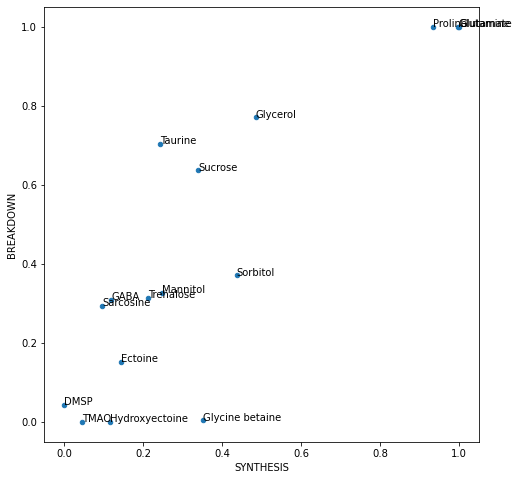

In [30]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8,8)
ax.set_aspect('equal')
summedbact.plot(kind='scatter', x='SYNTHESIS', y='BREAKDOWN', ax = ax)
for i in summedbact.index:
    ax.text(summedbact.loc[i,'SYNTHESIS'], summedbact.loc[i,'BREAKDOWN'], i)

In [31]:
taxdf = MarRef[[ 'kingdom',
 'phylum',
 'class',]]
taxdf[taxdf['kingdom']=='Archaea']='Archaea'
taxdf[taxdf['phylum']=='Aquificae (Phylum)']='Aquificae'
taxdf = taxdf.dropna()

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/pandas/core/frame.py:3059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer(indexer, value)
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/pandas/core/frame.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a co

In [32]:
proteobacteria = taxdf[taxdf['phylum']=='Proteobacteria']
other = taxdf[taxdf['phylum']!='Proteobacteria']

In [33]:
other[other['phylum']=='Acidobacteria']


,kingdom,phylum,class
assembly_accession_refseq,,,
NaN,Bacteria,Acidobacteria,Unclassified


In [34]:
for g,d in other.groupby('phylum'):
    print(g)
    print(d)
    i = d.index
    i = i.dropna()
    print(i)
    other.loc[i,'class']=g

Acidobacteria
                            kingdom         phylum         class
assembly_accession_refseq                                       
NaN                        Bacteria  Acidobacteria  Unclassified
Index([], dtype='object', name='assembly_accession_refseq')
Actinobacteria
                            kingdom          phylum           class
assembly_accession_refseq                                          
GCF_003970715.1            Bacteria  Actinobacteria  Actinobacteria
Index(['GCF_003970715.1'], dtype='object', name='assembly_accession_refseq')
Actinobacteria (Phylum)
                            kingdom                   phylum  \
assembly_accession_refseq                                      
GCF_000204155.1            Bacteria  Actinobacteria (Phylum)   
GCF_000954115.1            Bacteria  Actinobacteria (Phylum)   
GCF_000266905.1            Bacteria  Actinobacteria (Phylum)   
GCF_000230895.2            Bacteria  Actinobacteria (Phylum)   
GCF_000835165.1            

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

In [35]:
other.groupby(['phylum', 'class']).count()

kingdom
phylum                         class                                  
Acidobacteria                  Unclassified                          1
Actinobacteria                 Actinobacteria                        1
Actinobacteria (Phylum)        Actinobacteria (Class)                1
                               Actinobacteria (Phylum)              62
Aquificae                      Aquificae                             3
Archaea                        Archaea                              99
Bacteroidetes                  Bacteroidetes                       112
                               Flavobacteriia                        2
Calditrichaeota                Calditrichaeota                       1
Chlorobi                       Chlorobi                              5
Chloroflexi                    Chloroflexi                           1
Cyanobacteria                  Cyanobacteria                        39
                               Unclassified                          3
Deferribacteres (Phylum)       Deferribacteres (Phylum)              3
Deinococcus-Thermus            Deinococcus-Thermus                   2
Firmicutes                     Bacilli                               6
                               Clostridia                            1
                               Firmicutes                           46
                               Unclassified                          1
Fusobacteria                   Fusobacteria                          1
Planctomycetes                 Planctomycetes                        1
Spirochaetes                   Spirochaetes                          2
Synergistetes                  Synergistetes                         1
Tenericutes                    Tenericutes                           3
Thermodesulfobacteria (Phylum) Thermodesulfobacteria (Phylum)        1
Thermotogae (Phylum)           Thermotogae (Phylum)                 20
Unclassified                   Unclassified                          2
Verrucomicrobia                Opitutae                              1
                               Verrucomicrobia                       2

In [36]:
MarRef.groupby(['phylum', 'class']).count()

base_ID  \
phylum                         class                                    
Acidobacteria                  Unclassified                         1   
Actinobacteria                 Actinobacteria                       1   
Actinobacteria (Phylum)        Actinobacteria (Class)              61   
                               Nitriliruptoria                      1   
                               Rubrobacteria                        1   
Aquificae                      Aquificae                            1   
Aquificae (Phylum)             Aquificae (Class)                    2   
Bacteroidetes                  Bacteroidia                          2   
                               Cytophagia                          12   
                               Flavobacteriia                      88   
                               Sphingobacteriia                     1   
                               Unclassified                        11   
Calditrichaeota                Calditrichae                         1   
Candidatus Nanohaloarchaeota   Nanohaloarchaea                      1   
Chlorobi                       Chlorobia                            5   
Chloroflexi                    Anaerolineae                         1   
Crenarchaeota                  Thermoprotei                        10   
Cyanobacteria                  Cyanophyceae                         1   
                               Oscillatoriophycideae                6   
                               Unclassified                        35   
Deferribacteres (Phylum)       Deferribacteres (Class)              3   
Deinococcus-Thermus            Deinococci                           2   
Euryarchaeota                  Archaeoglobi                         7   
                               Halobacteria                        18   
                               Methanobacteria                      2   
                               Methanococci                        16   
                               Methanomicrobia                     11   
                               Methanopyri                          1   
                               Thermococci                         20   
                               Thermoplasmata                       1   
                               Unclassified                         3   
Firmicutes                     Bacillales (Class)                   3   
                               Bacilli                             41   
                               Clostridia                           8   
                               Erysipelotrichia                     1   
                               Unclassified                         1   
Fusobacteria                   Fusobacteriia                        1   
Nanoarchaeota                  Unclassified                         1   
Planctomycetes                 Phycisphaerae                        1   
Proteobacteria                 Alphaproteobacteria                143   
                               Betaproteobacteria                  12   
                               Deltaproteobacteria                 19   
                               Epsilonproteobacteria               14   
                               Gammaproteobacteria                355   
                               Oligoflexia                          2   
                               Zetaproteobacteria                   2   
Spirochaetes                   Spirochaetia                         2   
Synergistetes                  Synergistia                          1   
Tenericutes                    Mollicutes                           2   
                               Unclassified                         1   
Thaumarchaeota                 Unclassified                         8   
Thermodesulfobacteria (Phylum) Thermodesulfobacteria (Class)        1   
Thermotogae (Phylum)           Thermotogae (Class)                 20   
Unclassified                   Unclassified    

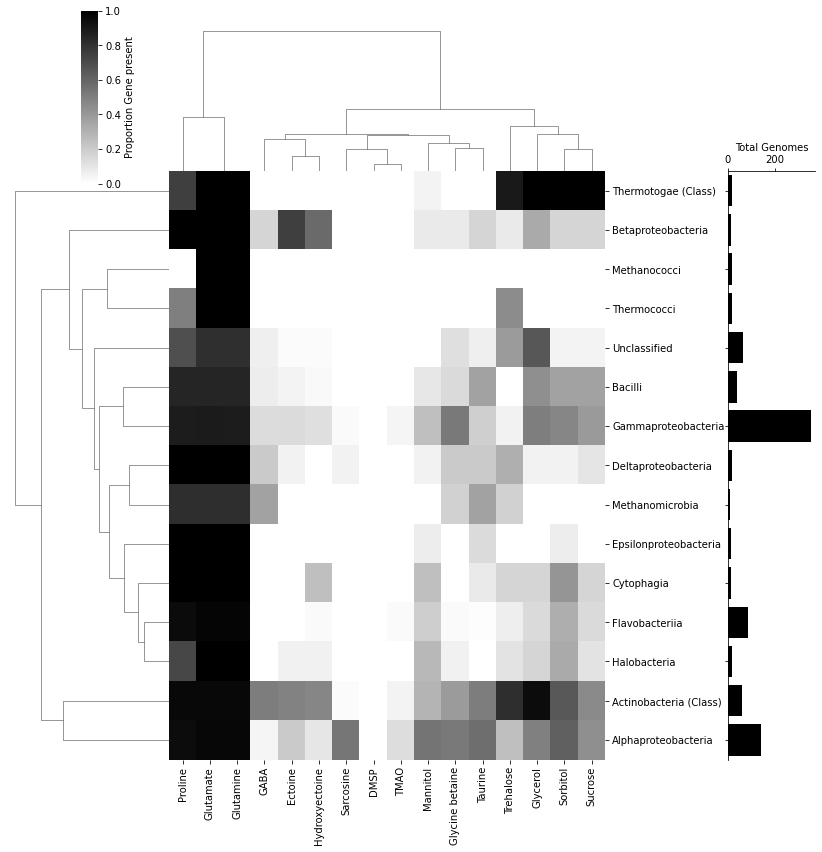

In [37]:
Sdivision_bact, Stotal_bac_group  = bact_groupby(SYNTH,  level='class', normalized=True)
create_cluster_bar(Sdivision_bact, Stotal_bac_group, genome=True, cutoff=True, c=10)

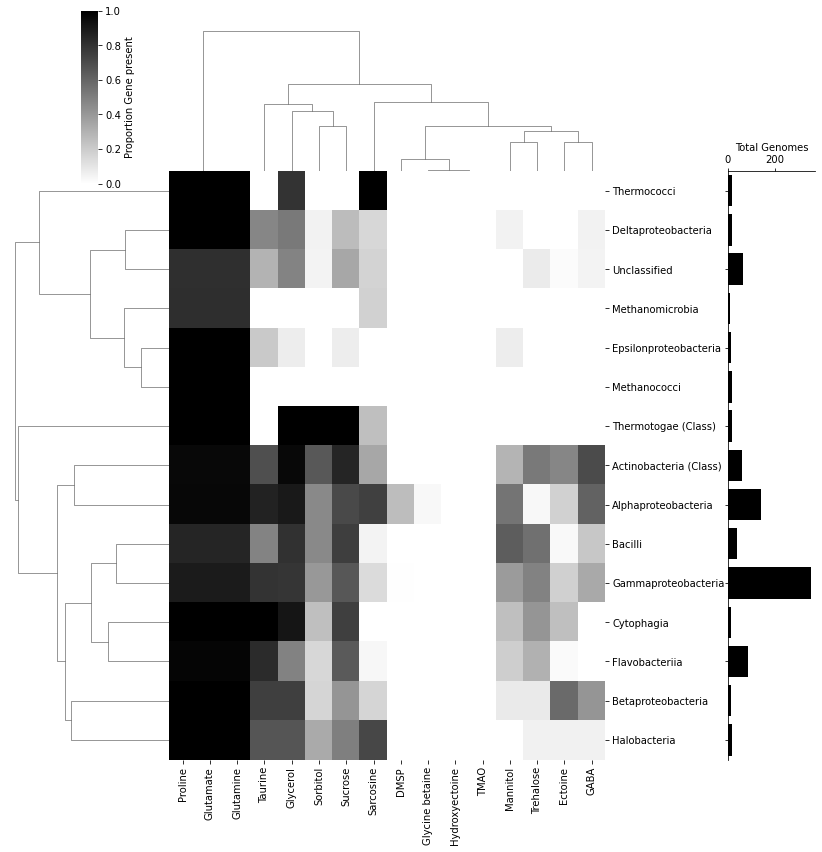

In [38]:
Bdivision_bact, Btotal_bac_group  = bact_groupby(BD,  level='class', normalized=True)
create_cluster_bar(Bdivision_bact, Btotal_bac_group, genome=True, cutoff=True, c=10)

In [78]:
SYNTH = bact_synth.xs('SYNTHESIS', level=1, drop_level=False, axis=1)

gb =  bact_synth.xs('Glycine betaine', level=0, drop_level=True, axis=1)
gbs = gb[gb['SYNTHESIS']==1]
gbs.merge(MarRef, left_index=True, right_index=True)[['kingdom',
 'phylum',
 'class',
 'order',
 'family',
 'genus',
 'species',]].to_csv('figures/Glycine_betain_taxonomy_synthesis.csv')

gbbd = gb[gb['BREAKDOWN']==1]
gbbd.merge(MarRef, left_index=True, right_index=True)[['kingdom',
 'phylum',
 'class',
 'order',
 'family',
 'genus',
 'species',]].to_csv('figures/Glycine_betain_taxonomy_breakdown.csv')

# Eukaryotes

In [20]:
euk_synth = pd.read_csv('../predict_synthesis/2021-03-predicted-mmetsp-osmolyte-synthesis.tsv', sep ='\t', header=[0, 1], index_col=0)
euk_synth.index = euk_synth.index.str.strip('_clean')

In [21]:
ESYNTH = euk_synth.xs('SYNTHESIS', level=1, drop_level=False, axis=1)
EBD = euk_synth.xs('BREAKDOWN', level=1, drop_level=False, axis=1)
ESYNTH.columns = ESYNTH.columns.droplevel(1)
EBD.columns = EBD.columns.droplevel(1)



In [22]:
Esummed = pd.DataFrame(ESYNTH.sum()/len(ESYNTH))
Ebd = pd.DataFrame(EBD.sum()/len(EBD))
Esummed=Esummed.merge(Ebd, left_index=True, right_index=True)
Esummed.columns=['SYNTHESIS', 'BREAKDOWN']
Esummed.sort_values('SYNTHESIS', ascending=False)

,SYNTHESIS,BREAKDOWN
Glutamate,0.995399,0.995399
Glutamine,0.992331,0.993865
Proline,0.915644,0.983129
Glycerol,0.811350,0.858896
Sorbitol,0.765337,0.751534
Sucrose,0.753067,0.644172
Trehalose,0.246933,0.361963
Taurine,0.242331,0.475460
GABA,0.214724,0.286810
Mannitol,0.124233,0.056748


In [23]:
S = pd.DataFrame(ESYNTH.sum())
S.columns=['Synthesis']
B = pd.DataFrame(EBD.sum())
B.columns=['Breakdown']
SB  = S.merge(B, left_index=True, right_index=True)
SB.to_csv('figures/Euk_Synthes_Breakdown_sum.csv')

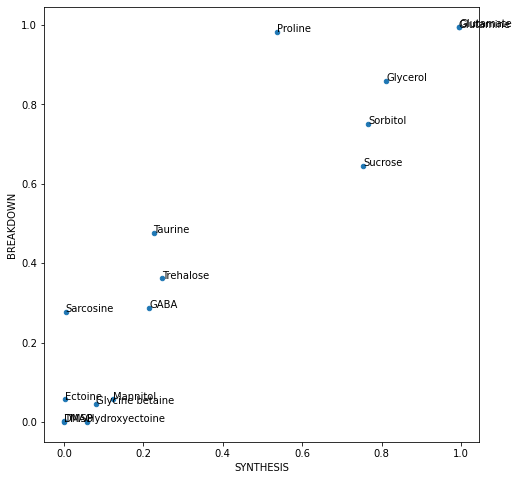

In [26]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8,8)
ax.set_aspect('equal')
Esummed.plot(kind='scatter', x='SYNTHESIS', y='BREAKDOWN', ax = ax)
for i in Esummed.index:
    ax.text(Esummed.loc[i,'SYNTHESIS'], Esummed.loc[i,'BREAKDOWN'], i)

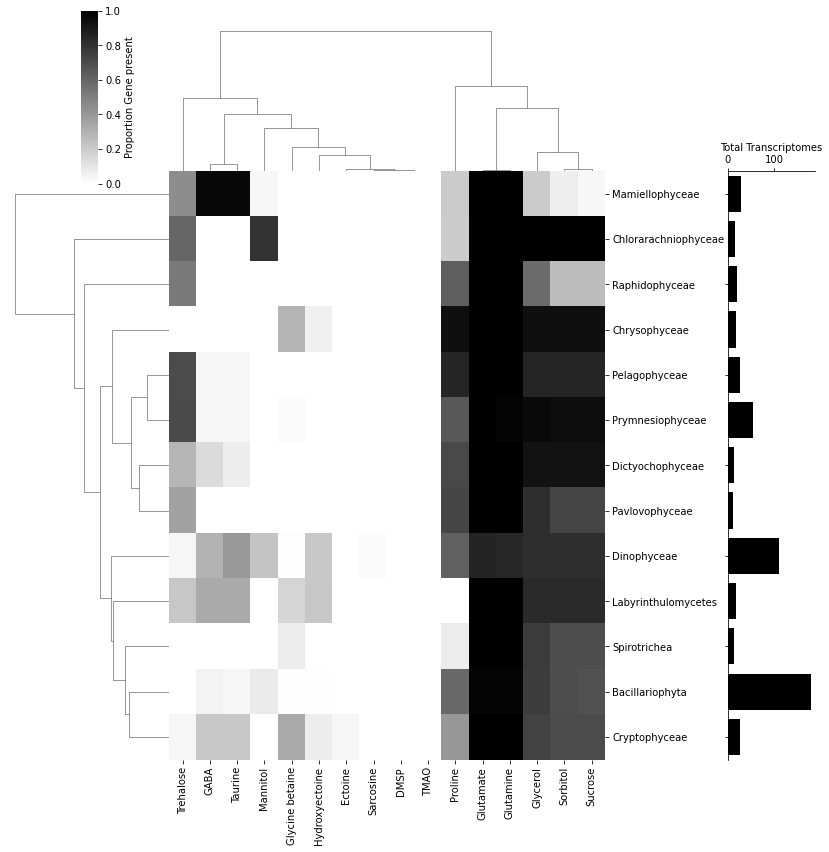

In [33]:
SEdivision, SEtotal_group  = MMETSP_groupby(ESYNTH,  level='Class', normalized=True)
create_cluster_bar(SEdivision, SEtotal_group, genome=False, cutoff=True, c=10)

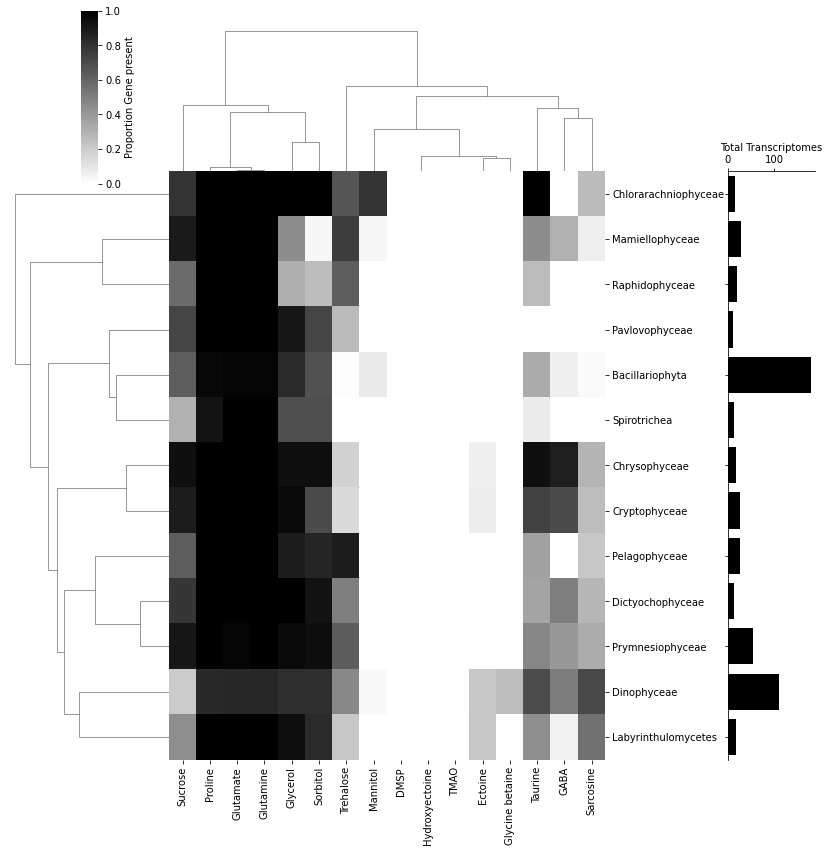

In [34]:
BEdivision, BEtotal_group  = MMETSP_groupby(EBD,  level='Class', normalized=True)
create_cluster_bar(BEdivision, BEtotal_group, genome=False, cutoff=True, c=10)